In [292]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [293]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.1.2'

In [294]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [295]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("/kaggle/input/fod-detection")
image_path = data_path / 'Data'
# Unzip data
# with zipfile.ZipFile(data_path / "Data", "r") as zip_ref:
# #     print("Unzipping pizza, steak, sushi data...") 
#     zip_ref.extractall(image_path)

train_dir = image_path / "Train"
val_dir = image_path / "Validation"
test_dir = image_path / "Test"
train_dir, val_dir, test_dir

(PosixPath('/kaggle/input/fod-detection/Data/Train'),
 PosixPath('/kaggle/input/fod-detection/Data/Validation'),
 PosixPath('/kaggle/input/fod-detection/Data/Test'))

Random image path: /kaggle/input/fod-detection/Data/Test/class_0/patch_DSC_075_17_9.jpg
Image class: class_0
Image height: 32
Image width: 32


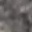

In [296]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

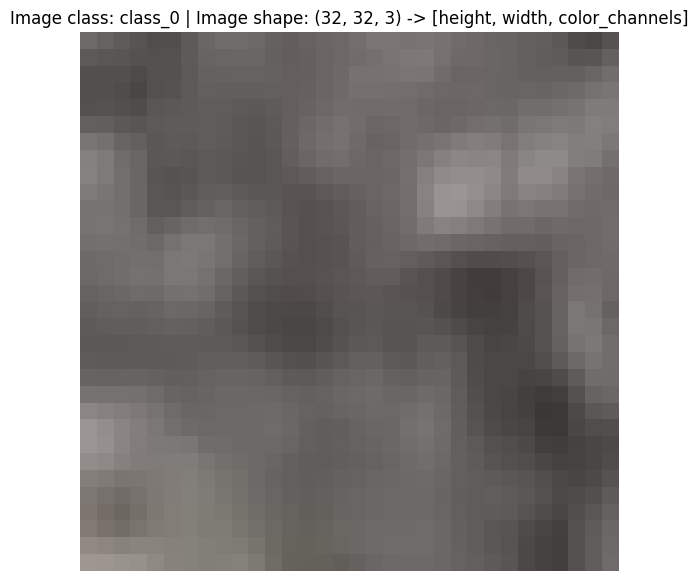

In [297]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [298]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [299]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
#     transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
#     transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

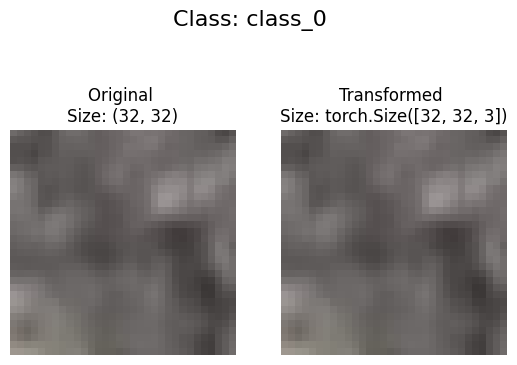

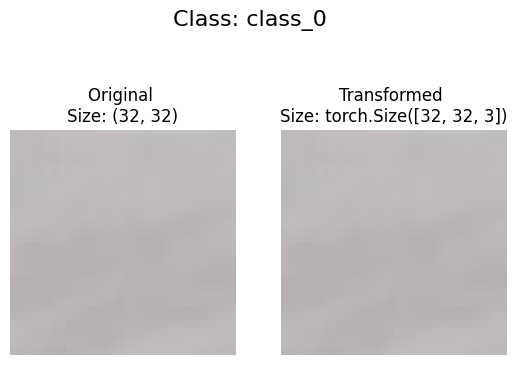

In [300]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=2)

In [301]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

val_data = datasets.ImageFolder(root=val_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nVal data:{val_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 24371
    Root location: /kaggle/input/fod-detection/Data/Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Val data:Dataset ImageFolder
    Number of datapoints: 3482
    Root location: /kaggle/input/fod-detection/Data/Validation
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 6964
    Root location: /kaggle/input/fod-detection/Data/Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [302]:
# Get class names as a list
class_names = train_data.classes
class_names

['class_0', 'class_1']

In [303]:
# Check the lengths
len(train_data), len(test_data)

(24371, 6964)

Image tensor:
tensor([[[0.4510, 0.4431, 0.4392,  ..., 0.1216, 0.0980, 0.0863],
         [0.4471, 0.4392, 0.4353,  ..., 0.1137, 0.1020, 0.0980],
         [0.4392, 0.4392, 0.4314,  ..., 0.1098, 0.1098, 0.1176],
         ...,
         [0.6941, 0.7020, 0.7176,  ..., 0.7804, 0.7098, 0.6314],
         [0.6824, 0.6824, 0.7098,  ..., 0.8549, 0.7412, 0.6039],
         [0.6706, 0.6667, 0.6980,  ..., 0.9020, 0.7529, 0.5804]],

        [[0.4627, 0.4549, 0.4510,  ..., 0.1176, 0.0941, 0.0824],
         [0.4588, 0.4510, 0.4471,  ..., 0.1098, 0.0980, 0.0941],
         [0.4510, 0.4510, 0.4431,  ..., 0.1059, 0.1059, 0.1137],
         ...,
         [0.6863, 0.6941, 0.7098,  ..., 0.7882, 0.7137, 0.6353],
         [0.6745, 0.6745, 0.7020,  ..., 0.8588, 0.7451, 0.6078],
         [0.6627, 0.6588, 0.6902,  ..., 0.9059, 0.7569, 0.5843]],

        [[0.4980, 0.4902, 0.4863,  ..., 0.1373, 0.1137, 0.1020],
         [0.4941, 0.4863, 0.4824,  ..., 0.1294, 0.1176, 0.1137],
         [0.4863, 0.4863, 0.4784,  ..., 0.12

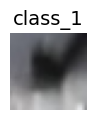

In [304]:
# for i in  range(24300):
img, label = train_data[24300][0], train_data[24300][1]
if (label == 1):
    print(f"Image tensor:\n{img}")
    print(f"Image shape: {img.shape}")
    print(f"Image datatype: {img.dtype}")
    print(f"Image label: {label}")
    print(f"Label datatype: {type(label)}")
    # Rearrange the order of dimensions
    img_permute = img.permute(1, 2, 0)

    # Print out different shapes (before and after permute)
    print(f"Original shape: {img.shape} -> [color_channels, height, width]")
    print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

    # Plot the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    plt.title(class_names[label], fontsize=14);

In [305]:
import os
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 128
NUM_WORKERS = 1
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

Creating DataLoader's with batch size 128 and 1 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7a3a80950f10>,
 <torch.utils.data.dataloader.DataLoader at 0x7a3ab62518d0>)

In [306]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([128, 3, 32, 32]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([128])


In [307]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [308]:
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

In [309]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [310]:
# from torchmetrics import F1Score
# from sklearn.metrics import precision_recall_curve

# f1 = F1Score(task = 'binary').to(device)

# def train_step(model: torch.nn.Module,
#                data_loader: torch.utils.data.DataLoader,
#                loss_fn: torch.nn.Module,
#                optimizer: torch.optim.Optimizer,
#                accuracy_fn,
#                device: torch.device = device):
#     train_loss, train_acc = 0, 0
    
#     model.to(device)
#     for batch, (X, y) in enumerate(data_loader):
#         # Send data to GPU
#         X, y = X.to(device), y.to(device)
#         y = y.max(dim=1)[0]
        
#         # 1. Forward pass
#         with autocast():  # mixed precision
#                 y_pred = model(X).float()

#         # 2. Calculate loss
#         loss = loss_fn(y_pred, y)
#         train_loss += loss
#         train_acc += accuracy_fn(y_true=y,
#                                  y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        

#         # 3. Optimizer zero grad
#         optimizer.zero_grad()

#         # 4. Loss backward
#         loss.backward()

#         # 5. Optimizer step
#         optimizer.step()

#     # Calculate loss and accuracy per epoch and print out what's happening
#     train_loss /= len(data_loader)
#     train_acc /= len(data_loader)
#     print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
#     return train_loss,train_acc

# def val_step(data_loader: torch.utils.data.DataLoader,
#               model: torch.nn.Module,
#               loss_fn: torch.nn.Module,
#               accuracy_fn,
#               device: torch.device = device):
#     val_loss, val_acc = 0, 0
#     precision, recall, f1_score = 0, 0, 0
#     model.to(device)
#     model.eval() # put model in eval mode
#     # Turn on inference context manager
#     with torch.inference_mode(): 
#         for X, y in data_loader:
#             # Send data to GPU
#             X, y = X.to(device), y.to(device)
            
#             # 1. Forward pass
#             val_pred = model(X)
            
#             # 2. Calculate loss and accuracy
#             val_loss += loss_fn(val_pred, y)
#             val_acc += accuracy_fn(y_true=y,
#                 y_pred=val_pred.argmax(dim=1) # Go from logits -> pred labels
#             )
# #             precision += precision_score(y_test, y_pred)
# #             recall += recall_score(y_test, y_pred)
# #             f1_score += f1(y_test, y_pred)
        
#         # Adjust metrics and print out
#         val_loss /= len(data_loader)
#         val_acc /= len(data_loader)
#         print(f"Val loss: {val_loss:.5f} | Val accuracy: {val_acc:.2f}%\n")
#     return val_loss,val_acc

# def test_step(data_loader: torch.utils.data.DataLoader,
#               model: torch.nn.Module,
#               loss_fn: torch.nn.Module,
#               accuracy_fn,
#               device: torch.device = device):
#     test_loss, test_acc = 0, 0
#     precision, recall, f1_score = 0, 0, 0
#     model.to(device)
#     model.eval() # put model in eval mode
#     # Turn on inference context manager
#     with torch.inference_mode(): 
#         for X, y in data_loader:
#             # Send data to GPU
#             X, y = X.to(device), y.to(device)
#             print(y)
#             # 1. Forward pass
#             test_pred = model(X)
# #             print(y.shape)
# #             print(test_pred)
# #             break
# #             print(test_pred.argmax(dim=1))
            
#             # 2. Calculate loss and accuracy
#             test_loss += loss_fn(test_pred, y)
#             test_acc += accuracy_fn(y_true=y,
#                 y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
#             )
# #             precision += precision_score(y, test_pred)
# #             recall += recall_score(y, test_pred)
#             f1_score += f1(y, test_pred.argmax(dim=1)).item()
        
#         # Adjust metrics and print out
#         test_loss /= len(data_loader)
#         test_acc /= len(data_loader)
#         f1_score /= len(data_loader)
#         print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        
#     rep = {
#             "Precision": precision,
#             "Recall": recall,
#             "F1 score": f1_score
#         }
#     return test_loss, test_acc, rep

In [322]:
def average_precision(output, target):
    epsilon = 1e-8

    # sort examples
    indices = output.argsort()[::-1]
    # Computes prec@i
    total_count_ = np.cumsum(np.ones((len(output), 1)))

    target_ = target[indices]
    ind = target_ == 1
    pos_count_ = np.cumsum(ind)
    total = pos_count_[-1]
    pos_count_[np.logical_not(ind)] = 0
    pp = pos_count_ / total_count_
    precision_at_i_ = np.sum(pp)
    precision_at_i = precision_at_i_ / (total + epsilon)

    return precision_at_i


def mAP(targs, preds):
    """Returns the model's average precision for each class
    Return:
        ap (FloatTensor): 1xK tensor, with avg precision for each class k
    """

    if np.size(preds) == 0:
        return 0
    ap = np.zeros((preds.shape[1]))
    # compute average precision for each class
    for k in range(preds.shape[1]):
        # sort scores
        scores = preds[:, k]
        targets = targs[:, k]
        # compute average precision
        ap[k] = average_precision(scores, targets)
    return 100 * ap.mean()

In [311]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

torch.manual_seed(42)
model_resnet = ResNet18().to(device)
# model_resnet = ResNet34()
# model_resnet = ResNet50()
# model_resnet = ResNet101()
# model_resnet = ResNet152()
# model_resnet

In [312]:
## sample testing by one forward pass on a single image

img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_resnet.eval()
with torch.inference_mode():
    pred = model_resnet(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 32, 32])

Output logits:
tensor([[ 0.0137, -0.0387]], device='cuda:0')

Output prediction probabilities:
tensor([[0.5131, 0.4869]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
0


In [313]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [332]:
from sklearn.metrics import confusion_matrix, classification_report
predictions=[]
true_labels=[]
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            
            predictions.extend(test_pred_labels.cpu().numpy())
            true_labels.extend(y.cpu().numpy())
            
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    print(confusion_matrix(true_labels,predictions))
    print(classification_report(true_labels, predictions, target_names=['Non FOD','FOD']))
    return test_loss, test_acc

In [315]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer
                                        )
        val_loss, val_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [316]:
class ASLSingleLabel(nn.Module):
    '''
    This loss is intended for single-label classification problems
    '''
    def __init__(self, gamma_pos=0, gamma_neg=4, eps: float = 0.1, reduction='mean'):
        super(ASLSingleLabel, self).__init__()

        self.eps = eps
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.targets_classes = []
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.reduction = reduction

    def forward(self, inputs, target):
        '''
        "input" dimensions: - (batch_size,number_classes)
        "target" dimensions: - (batch_size)
        '''
        num_classes = inputs.size()[-1]
        log_preds = self.logsoftmax(inputs)
        self.targets_classes = torch.zeros_like(inputs).scatter_(1, target.long().unsqueeze(1), 1)

        # ASL weights
        targets = self.targets_classes
        anti_targets = 1 - targets
        xs_pos = torch.exp(log_preds)
        xs_neg = 1 - xs_pos
        xs_pos = xs_pos * targets
        xs_neg = xs_neg * anti_targets
        asymmetric_w = torch.pow(1 - xs_pos - xs_neg,
                                 self.gamma_pos * targets + self.gamma_neg * anti_targets)
        log_preds = log_preds * asymmetric_w

        if self.eps > 0:  # label smoothing
            self.targets_classes = self.targets_classes.mul(1 - self.eps).add(self.eps / num_classes)

        # loss calculation
        loss = - self.targets_classes.mul(log_preds)

        loss = loss.sum(dim=-1)
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [317]:
# Setup loss and optimizer
loss_fn = ASLSingleLabel(gamma_neg=4, gamma_pos=0)
loss_fn = loss_fn.to(device)
# optimizer = torch.optim.SGD(model_resnet.parameters(), lr=0.1,momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(params=model_resnet.parameters(), lr=0.001)
## Scheduler changes learning rate after each epoch
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [318]:
torch.manual_seed(42)


torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_resnets
model_resnet_results = train(model=model_resnet, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0389 | train_acc: 0.9879 | val_loss: 0.0380 | val_acc: 0.9903
Epoch: 2 | train_loss: 0.0161 | train_acc: 0.9959 | val_loss: 0.0271 | val_acc: 0.9917
Epoch: 3 | train_loss: 0.0127 | train_acc: 0.9961 | val_loss: 0.0248 | val_acc: 0.9926
Epoch: 4 | train_loss: 0.0116 | train_acc: 0.9961 | val_loss: 0.0221 | val_acc: 0.9933
Epoch: 5 | train_loss: 0.0106 | train_acc: 0.9967 | val_loss: 0.0184 | val_acc: 0.9943
Epoch: 6 | train_loss: 0.0122 | train_acc: 0.9961 | val_loss: 0.0150 | val_acc: 0.9959
Epoch: 7 | train_loss: 0.0097 | train_acc: 0.9970 | val_loss: 0.0159 | val_acc: 0.9950
Epoch: 8 | train_loss: 0.0086 | train_acc: 0.9974 | val_loss: 0.0113 | val_acc: 0.9968
Epoch: 9 | train_loss: 0.0087 | train_acc: 0.9971 | val_loss: 0.0114 | val_acc: 0.9976
Epoch: 10 | train_loss: 0.0079 | train_acc: 0.9975 | val_loss: 0.0172 | val_acc: 0.9955
Epoch: 11 | train_loss: 0.0066 | train_acc: 0.9978 | val_loss: 0.0094 | val_acc: 0.9983
Epoch: 12 | train_loss: 0.0067 | train_ac

In [319]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss_ASL')
    plt.plot(epochs, test_loss, label='val_loss_ASL')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy_ASL')
    plt.plot(epochs, test_accuracy, label='val_accuracy_ASL')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

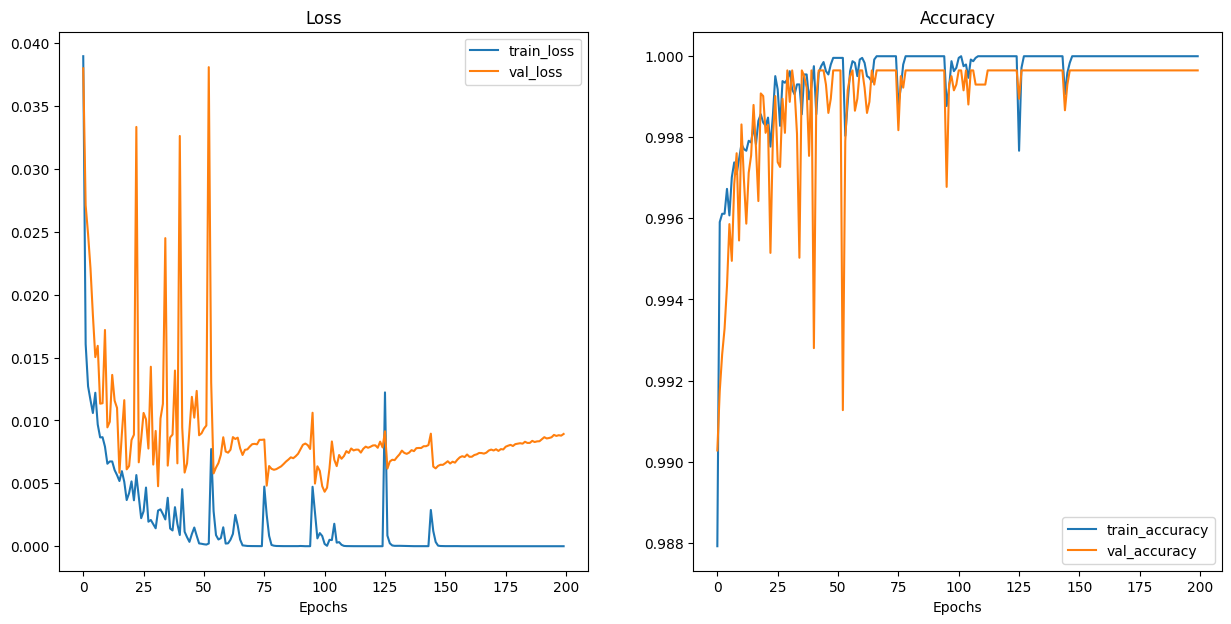

In [320]:
plot_loss_curves(model_resnet_results)

In [333]:
## Test Results
test_loss, test_acc = test_step(model=model_resnet,
            dataloader = test_dataloader,
            loss_fn=loss_fn
            )

print(f"test_loss: {test_loss}, test_acc: {test_acc}")
# report

[[6898    0]
 [   1   65]]
              precision    recall  f1-score   support

     Non FOD       1.00      1.00      1.00      6898
         FOD       1.00      0.98      0.99        66

    accuracy                           1.00      6964
   macro avg       1.00      0.99      1.00      6964
weighted avg       1.00      1.00      1.00      6964

test_loss: 0.008923345581536941, test_acc: 0.9996503496503497
